In [1]:
import mne 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy

In [2]:
#Load unshuffled acc
subjects = ['sub05','sub06', 'sub07', 'sub08','sub09','sub10','sub11','sub12','sub13','sub14','sub15','sub16',
'sub18','sub19','sub20','sub21','sub22','sub23', 'sub25', 'sub26', 'sub27', 'sub28', 'sub29', 'sub30', 
'sub31', 'sub32', 'sub33', 'sub34', 'sub35', 'sub36', 'sub37', 'sub38', 'sub39', 'sub40', 'sub41', 'sub42', 'sub43', 
'sub44', 'sub45', 'sub46', 'sub47', 'sub48', 'sub49', 'sub50', 'sub51', 'sub52', 'sub53', 'sub55', 'sub56', 
'sub57', 'sub58', 'sub59', 'sub60', 'sub61', 'sub62',  
'sub64', 'sub65', 'sub66', 'sub67', 'sub68', 'sub69', 'sub70', 'sub72']


acctr = []
for subject in subjects:
    print(subject)
    acc_unshuff = pd.read_csv("../trf_results/{s}/fits_linguistic_{s}_within_nb_stan.csv".format(s=subject))
    
    
    acc_shuff = []

    feats = [ 'ling_word_target', 'ling_word_dis']

    #Load shuffled acc
    numit = 50
    for feat in feats:
        for it in range(0,numit):
            shuff = pd.read_csv("../trf_results/{s}/shuffle/fits_linguistic_{s}_{i}_{f}_within_nb_stan.csv".format(s = subject, i = it, f = feat))
            shuff['feature'] = shuff['feature_shuffle']
            shuff['subject'] = subject
            acc_shuff.append(shuff)
    
    acc_shuff = pd.concat(acc_shuff)
    
    acc_shuff = acc_shuff.groupby(['trialnum', 'channel', 'window', 'feature', 'subject'], as_index = False).mean('fit')              
    
    #Merge 
    accmere = pd.merge(acc_unshuff, acc_shuff, on = ['subject', 'trialnum', 'channel', 'window', 'feature'])
    accmere['fitsub'] = accmere['fit_x'] - accmere['fit_y'] 

    acctr.append(accmere)

sub05
sub06
sub07
sub08
sub09
sub10
sub11
sub12
sub13
sub14
sub15
sub16
sub18
sub19
sub20
sub21
sub22
sub23
sub25
sub26
sub27
sub28
sub29
sub30
sub31
sub32
sub33
sub34
sub35
sub36
sub37
sub38
sub39
sub40
sub41
sub42
sub43
sub44
sub45
sub46
sub47
sub48
sub49
sub50
sub51
sub52
sub53
sub55
sub56
sub57
sub58
sub59
sub60
sub61
sub62
sub64
sub65
sub66
sub67
sub68
sub69
sub70
sub72


In [3]:
acctr = pd.concat(acctr)

In [4]:
from mne.stats import spatio_temporal_cluster_1samp_test

sigres = []
subjectacc_sig = []
for f,fdf in acctr.groupby('feature'):
    featac = []
    print(f)
    datalist = []
    for s,sdf in fdf.groupby('subject'):
       # print(s)
        dfm = sdf.groupby(['channel', 'window'], as_index = False, sort = False)['fitsub'].mean()

        channel_order = dfm['channel'].unique()
        dfm['channel'] = pd.Categorical(dfm['channel'], categories=channel_order, ordered=True)

        pivoted = dfm.pivot(index='window', columns='channel', values='fitsub')

        d = pivoted.to_numpy()
        datalist.append(d)

    datalist = np.array(datalist)
    print(datalist.shape)

    #Do significance testing 

    #Create adjacency 
    subject="sub05"
    eeg_path = "./eeg_mne/saved_{sub}_new-epo.fif".format(sub = subject)
    
    ep = mne.read_epochs(eeg_path)
    ep = ep.drop_channels(['A1', 'A2'])

    channels = dfm['channel'].unique()
    
    ep_filt = ep.copy().pick(list(channels))
    ad,ch= mne.channels.find_ch_adjacency(ep_filt.info, ch_type = "eeg")
    ad = mne.stats.combine_adjacency(datalist.shape[1], ad)

    res = spatio_temporal_cluster_1samp_test(
    datalist,
    verbose=True, adjacency = ad, seed = 1, n_jobs = 5,
        tail = 1
    )


    cor_mean =np.mean(np.array(datalist), axis = 0)
    incor_mean = np.mean(np.array(datalist), axis = 0)
    diff_trf = cor_mean-incor_mean
    
    t_obs, clusters, pvals, h0 = res
    cluster_alpha = 0.05
    ncs = 0
    if len(res[1]) > 0:
            # no idea what is happening here
        nan_trf = np.ones_like(cor_mean) * np.nan
        nan_trf = np.ones_like(cor_mean) * np.nan
        nan_trf_list = np.ones_like(cor_mean) * np.nan
        nan_diff = nan_trf.copy()
        ncs = 0
        for k_cluster, c in enumerate(clusters):
            
          
            if pvals[k_cluster] < cluster_alpha:
                ncs = ncs+1
                lags = c
                ct = c[c == True]
                
                if len(set(ct)) > 0:
                    if abs(cor_mean[lags].mean()) > abs(incor_mean[lags].mean()):
                        nan_trf[lags] = cor_mean[lags]
                    else:
                        nan_trf_list[lags] = incor_mean[lags]
                    nan_diff[lags] = diff_trf[lags]
                    
                signi_times_t = (~np.isnan(nan_diff)).astype(float)
                signi_times_t[signi_times_t == 0.] = np.nan
                signi_chans_bool_t = (~np.all(np.isnan(nan_diff), axis=0))
        
            
    else:
        signi_times_t = diff_trf
        signi_chans_bool_t = np.nan
    
    if ncs == 0:
        signi_times_t = diff_trf
        signi_chans_bool_t = np.nan

    sigres.append(signi_times_t)
    
    #Filter the original dfs for significant sensors & channels 

    for sar in datalist:
        
        bool_mask = signi_times_t == 1
        print(bool_mask)
        #Filter only for time 
        time_points_with_true = np.any(bool_mask, axis=1)

        # Set all channels to True for those time points
        bool_mask[time_points_with_true] = True
        
        
        
        # Apply the mask to filter the data array
        filtered = np.where(bool_mask, sar, np.nan)
        subac = np.nanmean(filtered)

        featac.append(subac)

    subjectacc_sig.append(featac)
        

        

ling_word_target
(63, 38, 61)
Reading /data/pt_03114/trf_analysis_yo/eeg_mne/saved_sub05_new-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    6000.00 ms
        0 CTF compensation matrices available
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 61
Using a threshold of 1.669804
stat_fun(H1): min=-2.8284719129017226 max=4.533263355064738
Running initial clustering …
Found 13 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

13
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True False ...  True False False]
 [ True False False ... False False False]
 [ True False False ... False False False]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True False ...  True False False]
 [ True False False ... False False False]
 [ True False False ... False False False]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True False ...  True False False]
 [ True False False ... False False False]
 [ True False False ... False False False]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True False ...  True False False]
 [ True False False ... Fals

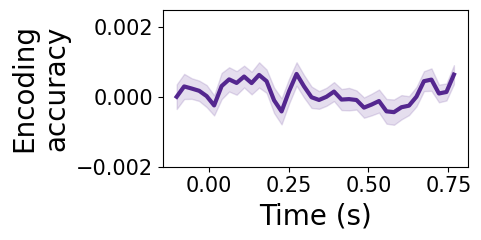

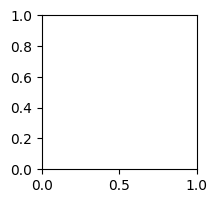

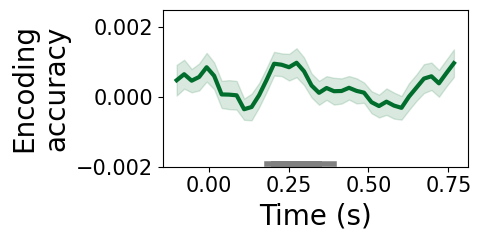

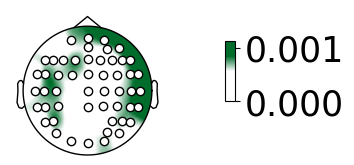

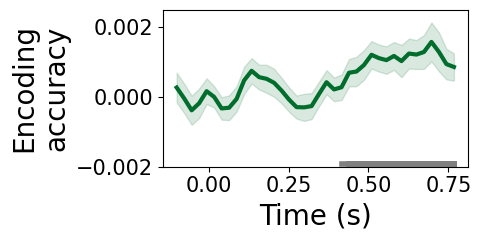

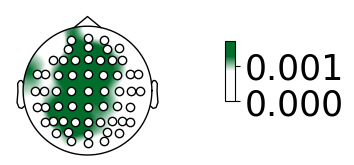

In [8]:
#Plot the mean acc 
import matplotlib.colors as clr

feats = acctr['feature'].unique()

for ifeat, feat in enumerate(feats): 
    dat = acctr.copy()
        
    datsub = dat[dat['feature'] == feat].groupby(['window', 'subject'], as_index = False).mean('fitsub')
    
    stan = datsub.groupby([ 'window'], as_index = False)['fitsub'].sem()
    stan = stan.rename(columns={"fitsub": "std"})
    
    dat = acctr.copy()
    dat = dat[dat['feature'] == feat].groupby(['window'], as_index = False).mean('fitsub')
    dat_std = pd.merge(dat, stan, on = ['window'])
    
    t = sigres[ifeat].copy()
    
    if np.any(t == 1) == False:
        t = t
        t[t == 0] = np.nan
    else:
        t = t

    x = np.arange(-0.1, 0.78, 1/128*3)
    dat_std['x'] = x
    
    
    fig,ax=plt.subplots(figsize=[5,2.5], ncols = 1)
    
    cdict = {"ac_target": "#006D2C","ac_dis":"#54278F", 
                "onsets_target": "#006D2C", "onsets_target_incor": "#00838CFF", "onsets_dis":"#54278F", "onsets_dis_incor":"#525DA6FF", 
                "ling_word_target": "#006D2C", "ling_word_target_incor": "#00838CFF", "ling_word_dis":"#54278F", "ling_word_dis_incor":"#525DA6FF", 
                "ling_phone_target": "#006D2C", "ling_phoneme_target_incor": "#00838CFF", "ling_phone_dis":"#54278F", "ling_phoneme_dis_incor":"#525DA6FF"
                ,"acon_target": "#006D2C","acon_dis":"#54278F", 
                "ling_target": "#006D2C","ling_dis":"#54278F", 
            "ws_target": "#006D2C","ws_dis":"#54278F", 
            "we_target": "#006D2C","we_dis":"#54278F"}
    
    cmap = clr.LinearSegmentedColormap.from_list('custom blue', ['white','white','white', cdict["ling_word_target"], cdict["ling_word_target"]], N=256)
    
    ax.plot(dat_std['x'], dat_std['fitsub'], label=feat, linewidth = 3, color = cdict[feat])
    ax.fill_between(dat_std['x'],  dat_std['fitsub'] + dat_std['std'], dat_std['fitsub'] - dat_std['std'], 
                       alpha = .15, color = cdict[feat])
    
   # ax.legend()
    ax.set_xlabel("Time (s)",size=20)
    ax.set_ylabel("Encoding\naccuracy",size=20)
    
    ax.tick_params(axis='both', which='major', labelsize=15)
    
    # ax.axhline(y=-0.0022, color='grey', linestyle='-', linewidth = 5, alpha = .5, xmin = 0.57, xmax = 0.96)
    plt.plot(dat_std['x'], t*0+0.02, lw=4, transform=ax.get_xaxis_transform(), color = "grey")
    plt.ylim((-0.002,0.0025))
    fig.tight_layout()

    

    #Define topo windows
    windows = {'ling_phone_dis':[0.25, 0.35], 'ling_phone_target': [0.2, 0.4], 'ling_word_dis':[0.4, 0.5], 'ling_word_target':[0.5, 0.6], 
              'ws_target':[0.4, 0.6], 'ws_dis':[0.4, 0.6],
              'we_target':[0.4, 0.6], 'we_dis':[0.4, 0.6]}
    
    #plt.hlines(y = 0.04, xmin = windows[feat][0], xmax = windows[feat][1],transform=ax.get_xaxis_transform(), lw=4, color = "black")
    plt.savefig("../figures/{f}_tracc.svg".format(f = feat))




    #PLot the topomap for the selected windows


    fig,ax = plt.subplots(ncols = 1, figsize = (2,2))

   

    tz = np.nan_to_num(t)
    windsig = np.unique(np.nonzero(tz)[0])

    if len(windsig) > 1:
        ar = sigres[ifeat][windsig]
        ar = np.nan_to_num(ar)
    
        mask = np.any(ar == 1, axis=0)
    
        dat = acctr.copy()
        
        datw = dat[dat['feature'] == feat].groupby(['window', 'channel'], as_index = False).mean('fitsub')
        data_window = datw[(datw['window'].isin(windsig))]
    
        
        f = data_window.groupby("channel").mean("fitsub")
        f = f['fitsub']
        
        f = f.reset_index()
        
        info = mne.create_info(ch_names=f['channel'].tolist(), sfreq=1000, ch_types='eeg')
        
       
        data = f['fitsub']
        
        # Load the standard 10-20 montage
        montage = mne.channels.make_standard_montage('biosemi64')
        
        # Extract all positions from the montage
        pos = montage.get_positions()['ch_pos']
        
        # Filter positions to include only those channels in your DataFrame
        pos = {ch: pos[ch] for ch in f['channel'].tolist()}
        
        
        info.set_montage(montage)
      
        
        # Convert positions to an array in the correct order
        pos_array = np.array([pos[ch][:2] for ch in f['channel'].tolist()])
    
    
    
    
        im,cm = mne.viz.plot_topomap(data, pos=info, size = 5,contours = 0,image_interp = "cubic",
                                     mask = mask,
                                     sensors = False,extrapolate="head", ch_type = "eeg", show=False, axes=ax, 
                                        mask_params = dict(marker='o', markerfacecolor='white', markeredgecolor='black',
                                        markersize=6),cmap=cmap
                                     #vlim= (0, maxv)
        )
        
    
        ax_x_start = 1.2
        ax_x_width = 0.05
        ax_y_start = 0.4
        ax_y_height = 0.3
        cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
        clb = fig.colorbar(im, cax=cbar_ax)
        clb.ax.tick_params(labelsize=25)
       
        
        plt.savefig("../figures/topo_trwind_{f}.svg".format(f = feat), bbox_inches = "tight")
    


In [15]:


from mne.stats import spatio_temporal_cluster_1samp_test
ifeats = [1,1,3,3]
ifeats = [0,0,0,0]
ifeat = 0
subjectacc_sig_trials = []
for f,fdf in acctr.groupby('feature'):
    featac = []
    print(f)
    datalist = []
    for s,sdf in fdf.groupby('subject'):
        triallist = []
        for tn, tdf in sdf.groupby('trialnum'):
    
            channel_order = tdf['channel'].unique()
            tdf['channel'] = pd.Categorical(tdf['channel'], categories=channel_order, ordered=True)
    
            pivoted = tdf.pivot(index='window', columns='channel', values='fitsub')
    
            d = pivoted.to_numpy()
            triallist.append(d)
        datalist.append(triallist)
        
    datalist = np.array(datalist)
    print(datalist.shape)

    indf = ifeats[ifeat]
    signi_times_t = sigres[indf]

    for sar in datalist:
        tac = []
        for tar in sar:
            bool_mask = signi_times_t == 1

            
                
            #Filter only for time 
          
            time_points_with_true[:21] = False
            time_points_with_true[21:] = True

           
            # Set all channels to True for those time points
            bool_mask[time_points_with_true] = True
            
    
            # Apply the mask to filter the data array
            filtered = np.where(bool_mask, tar, np.nan)
            subac = np.nanmean(filtered)
    
            featac.append(subac)

    subjectacc_sig_trials.append(featac)
    ifeat = ifeat + 1

    

ling_word_target
(63, 200, 38, 61)


In [16]:
unique_combos = acctr[['subject', 'trialnum']].drop_duplicates().reset_index(drop=True)


unique_combos['ling_word_target'] = subjectacc_sig_trials[1]

dfsave = unique_combos.melt(id_vars = ['subject', 'trialnum'], value_vars = ['ling_word_target'], 
                   var_name = 'feat', value_name = 'correlation')

dfsave.to_csv("../statistics/tr_fits_ling.csv")